# ValueInvestor

**Goal(s):**

Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.

**Data Description:**

A set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged.

**Success Metrics:**

Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

In [ ]:
pip install tpot

In [ ]:
pip install scikit-optimize

In [ ]:
pip install git+https://github.com/hyperopt/hyperopt-sklearn

In [1]:
#importing libraries
import os
import math
import imblearn
import numpy as np
import pandas as pd
import warnings
from hyperopt import tpe
import seaborn as sns
from tpot import TPOTClassifier
warnings.filterwarnings('ignore')
from datetime import date
from skopt import BayesSearchCV
from fbprophet import Prophet
from tensorflow import keras
import matplotlib.pyplot as plt
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from numpy import unique
from numpy import argmax
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from collections import Counter
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import  GRU
from tensorflow.keras.optimizers import SGD
from keras.layers.recurrent_v2 import GRU
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
#open data
dfColombia = pd.read_excel('2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name = 'Colombia - Cementos Argos SA (C') 
dfColombia

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,5150.0,5100.0,5170.0,5100.0,212.44K,0.0098
1,2021-03-30 00:00:00,5100.0,5010.0,5100.0,5010.0,583.70K,0.0109
2,2021-03-29 00:00:00,5045.0,5020.0,5045.0,5015.0,117.54K,0.0050
3,2021-03-26 00:00:00,5020.0,5085.0,5085.0,4980.0,203.46K,-0.0020
4,2021-03-25 00:00:00,5030.0,5035.0,5045.0,4950.0,317.06K,0.0010
...,...,...,...,...,...,...,...
299,2020-01-08 00:00:00,6880.0,6940.0,6950.0,6880.0,84.93K,-0.0101
300,2020-01-07 00:00:00,6950.0,6950.0,6950.0,6850.0,168.71K,-0.0071
301,2020-01-03 00:00:00,7000.0,7040.0,7100.0,6960.0,470.77K,-0.0169
302,2020-01-02 00:00:00,7120.0,7300.0,7300.0,7120.0,138.96K,-0.0247


In [4]:
# splitting dataframe by row
df_1 = dfColombia.iloc[:303,:]
df_2 = dfColombia.iloc[303:,:]

In [5]:
#replace - characters
df_1['Change %'] = df_1['Change %'].astype('string')
df_1['Vol.'] = df_1['Vol.'].astype('string')

In [6]:
df_1['Change %'] = df_1['Change %'].str.replace("%", " ")
#replace - characters
df_1['Vol.'] = df_1['Vol.'].str.replace("M", " ")
#replace - characters
df_1['Vol.'] = df_1['Vol.'].str.replace("K", " ")
df_1['Vol.'] = df_1['Vol.'].astype(float)
df_1['Price'] = df_1['Price'].astype(float)
df_1['Open'] = df_1['Open'].astype(float)
df_1['High'] = df_1['High'].astype(float)
df_1['Low'] = df_1['Low'].astype(float)
df_1['Change %'] = df_1['Change %'].astype(float)
#datetime
df_1['Date'] = pd.to_datetime(df_1['Date'])

In [7]:
#filter df by 2020
filtered_df = df_1[df_1["Date"].isin(pd.date_range('2020-2-1', '2020-12-31'))]
filtered_df

,Date,Price,Open,High,Low,Vol.,Change %
61,2020-12-30,6180.0,6180.0,6275.0,6020.0,651.79,0.0000
62,2020-12-29,6180.0,5900.0,6180.0,5900.0,876.72,0.0492
63,2020-12-28,5890.0,5705.0,5890.0,5705.0,339.87,0.0333
64,2020-12-24,5700.0,5780.0,5780.0,5700.0,10.42,-0.0087
65,2020-12-23,5750.0,5870.0,5890.0,5720.0,527.28,-0.0120
...,...,...,...,...,...,...,...
277,2020-02-07,6310.0,6360.0,6360.0,6280.0,400.12,-0.0125
278,2020-02-06,6390.0,6530.0,6540.0,6360.0,622.79,-0.0214
279,2020-02-05,6530.0,6590.0,6590.0,6510.0,584.24,0.0046
280,2020-02-04,6500.0,6530.0,6570.0,6500.0,469.99,-0.0031


In [8]:
#set index
current_df = filtered_df.set_index('Date')

In [9]:
#sma
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

In [10]:
closing_prices = current_df['Price'] # Use only closing prices

In [11]:
sma = get_sma(closing_prices, 20) # Get 20 day SMA

In [12]:
symbol = ' SA'

In [13]:
#bollinger bands
def get_bollinger_bands(prices, sma, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

In [14]:
bollinger_up, bollinger_down = get_bollinger_bands(closing_prices, sma)

In [15]:
current_df['sma_20'] = get_sma(current_df['Price'], 20)
current_df.tail()

,Price,Open,High,Low,Vol.,Change %,sma_20
Date,,,,,,,
2020-02-07,6310.0,6360.0,6360.0,6280.0,400.12,-0.0125,5740.5
2020-02-06,6390.0,6530.0,6540.0,6360.0,622.79,-0.0214,5804.5
2020-02-05,6530.0,6590.0,6590.0,6510.0,584.24,0.0046,5877.0
2020-02-04,6500.0,6530.0,6570.0,6500.0,469.99,-0.0031,5956.0
2020-02-03,6520.0,6630.0,6630.0,6520.0,80.97,0.0031,6017.0


In [16]:
#bollinger bands
current_df['upper_bb'], current_df['lower_bb'] = get_bollinger_bands(current_df['Price'], current_df['sma_20'], 20)
current_df.tail()

,Price,Open,High,Low,Vol.,Change %,sma_20,upper_bb,lower_bb
Date,,,,,,,,,
2020-02-07,6310.0,6360.0,6360.0,6280.0,400.12,-0.0125,5740.5,6712.648462,4768.351538
2020-02-06,6390.0,6530.0,6540.0,6360.0,622.79,-0.0214,5804.5,6770.391462,4838.608538
2020-02-05,6530.0,6590.0,6590.0,6510.0,584.24,0.0046,5877.0,6831.526060,4922.473940
2020-02-04,6500.0,6530.0,6570.0,6500.0,469.99,-0.0031,5956.0,6835.626715,5076.373285
2020-02-03,6520.0,6630.0,6630.0,6520.0,80.97,0.0031,6017.0,6873.998434,5160.001566


In [17]:
#crosspoints
buyers = current_df[current_df['Price'] <= current_df['lower_bb']]
sellers = current_df[current_df['Price'] >= current_df['upper_bb']]

In [18]:
actions = []
for i in range(len(current_df['Price'])):
  if current_df['Price'][i] < current_df['lower_bb'][i]:
    actions.append(1)
  elif current_df['Price'][i] > current_df['upper_bb'][i]:
    actions.append(0)   
  else:
    actions.append(2)
    

In [19]:
current_df['actions'] = actions

Regression and Classification Model combination.

In [26]:
#axis's
xOpen = current_df.Open.values
yPrice = current_df.Price.values
y_class = current_df.actions

In [27]:
#splitting
train_X, test_X = xOpen[0:int(0.725*(len(xOpen)))], xOpen[int(0.725*(len(xOpen))):]
train_Y, test_Y = yPrice[0:int(0.725*(len(yPrice)))], yPrice[int(0.725*(len(yPrice))):]
y_train_class, y_test_class = y_class[0:int(0.725*(len(y_class)))], y_class[int(0.725*(len(y_class))):]

In [28]:
train_X.shape

(160,)

In [30]:
train_X = train_X.reshape(160,1)

In [31]:

#number of features and number of classes
n_features = train_X.shape[1]
n_class = len(unique(y_class))


In [32]:
# input
visible = Input(shape=(n_features,))
hidden1 = Dense(160, activation='relu', kernel_initializer='he_normal')(visible)
hidden2 = Dense(160, activation='relu', kernel_initializer='he_normal')(hidden1)
# regression output
out_reg = Dense(1, activation='linear')(hidden2)
# classification output
out_clas = Dense(n_class, activation='softmax')(hidden2)
# define model
modelmix = Model(inputs=visible, outputs=[out_reg, out_clas])
# compile the keras model
modelmix.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')
# fit the keras model on the dataset
modelmix.fit(train_X, [train_Y,y_train_class], epochs=150, batch_size=1, verbose=2)
# make predictions on test set
yhat1, yhat2 = modelmix.predict(test_X)
# calculate error for regression model
error = mean_absolute_error(test_Y, yhat1)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

Epoch 1/150
160/160 - 1s - loss: 3177712.5000 - dense_2_loss: 3177164.5000 - dense_3_loss: 548.1539 - 1s/epoch - 8ms/step
Epoch 2/150
160/160 - 0s - loss: 27695.3184 - dense_2_loss: 27514.4961 - dense_3_loss: 180.8183 - 279ms/epoch - 2ms/step
Epoch 3/150
160/160 - 0s - loss: 48429.1367 - dense_2_loss: 48273.8203 - dense_3_loss: 155.3110 - 271ms/epoch - 2ms/step
Epoch 4/150
160/160 - 0s - loss: 52212.0742 - dense_2_loss: 51967.1953 - dense_3_loss: 244.8797 - 267ms/epoch - 2ms/step
Epoch 5/150
160/160 - 0s - loss: 49896.4766 - dense_2_loss: 49747.1953 - dense_3_loss: 149.2876 - 289ms/epoch - 2ms/step
Epoch 6/150
160/160 - 0s - loss: 84225.0391 - dense_2_loss: 84057.7031 - dense_3_loss: 167.3338 - 264ms/epoch - 2ms/step
Epoch 7/150
160/160 - 0s - loss: 74264.9062 - dense_2_loss: 74110.9766 - dense_3_loss: 153.9203 - 249ms/epoch - 2ms/step
Epoch 8/150
160/160 - 0s - loss: 64825.6680 - dense_2_loss: 64660.7422 - dense_3_loss: 164.9378 - 252ms/epoch - 2ms/step
Epoch 9/150
160/160 - 0s - loss

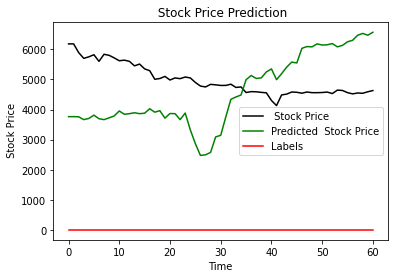

In [33]:
#plot results
plt.plot(yPrice[:61], color = 'black', label = ' Stock Price')
plt.plot(yhat1, color = 'green', label = 'Predicted  Stock Price')
plt.plot(yhat2, color = 'red', label = 'Labels')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

Time Series Classification.

In [34]:
#x shape
x_totrain = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))

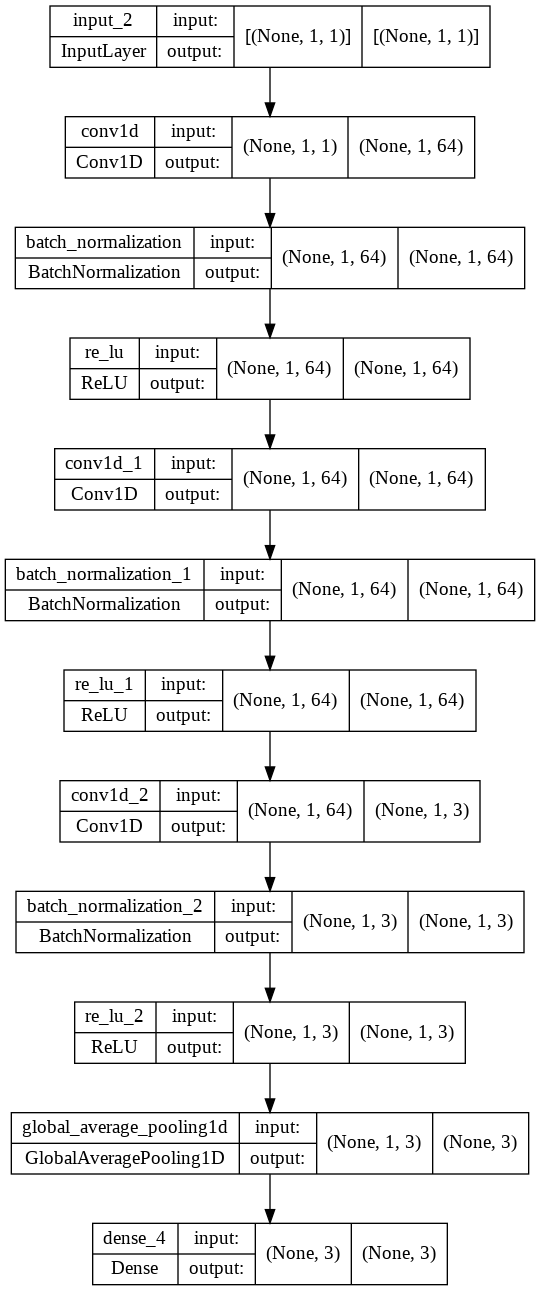

In [35]:
#model
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=3, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_class, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


modelkeras = make_model(input_shape=x_totrain.shape[1:])
keras.utils.plot_model(modelkeras, show_shapes=True)

In [37]:
#train
epochs = 50
batch_size = 4
optimizer = keras.optimizers.SGD(learning_rate=0.01)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
]
modelkeras.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = modelkeras.fit(
    x_totrain,
    y_train_class,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2)

Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.8319 - sparse_categorical_accuracy: 0.5703 - val_loss: 0.2229 - val_sparse_categorical_accuracy: 0.9688 - lr: 0.0100
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6891 - sparse_categorical_accuracy: 0.8750 - val_loss: 0.1755 - val_sparse_categorical_accuracy: 0.9688 - lr: 0.0100
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.3038 - val_sparse_categorical_accuracy: 0.9688 - lr: 0.0100
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5016 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.3586 - val_sparse_categorical_accuracy: 0.9688 - lr: 0.0100
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4742 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.5110 - val_sparse_categorical_accuracy: 0.9688 - lr: 0.0100
Epoch 6/50
32/32 [==========================

In [38]:
#x test reshape
retestxx = test_X.reshape(61,1)

In [39]:
x_totest = retestxx.reshape((retestxx.shape[0], retestxx.shape[1], 1))

In [40]:
#x test predict
yhatkeras = modelkeras.predict(x_totest)

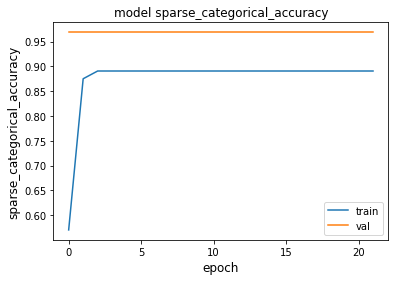

In [41]:
#plot results
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

Daily returns based on a percantage change in a price by row.

In [42]:
current_df['daily_returns'] = current_df['Price'].pct_change()

In [43]:
#count missing values
current_df['daily_returns'].isna().sum()

1

In [44]:
#remove missing values
current_df['daily_returns'].fillna(int(current_df['daily_returns'].mean()), inplace=True)

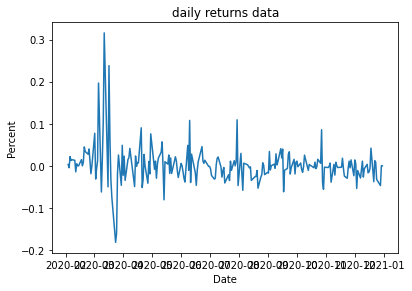

In [45]:
#plot results
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(current_df['daily_returns'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("daily returns data")
plt.show()

Testing Combination models to predict labels based on daily returns percantage change.

In [46]:
# axis's
xPrice = current_df.Price.values
yreturn = current_df.daily_returns.values
y_class = current_df.actions
#split
trainxxprice, testxxprice = xPrice[0:int(0.725*(len(xPrice)))], xPrice[int(0.725*(len(xPrice))):]
trainyreturns, testyreturns = yreturn[0:int(0.725*(len(yreturn)))], yreturn[int(0.725*(len(yreturn))):]
y_train_class, y_test_class = y_class[0:int(0.725*(len(y_class)))], y_class[int(0.725*(len(y_class))):]
trainxxprice = trainxxprice.reshape(160,1)
n_features = trainxxprice.shape[1]
n_class = len(unique(y_class))

In [47]:
# input
visible = Input(shape=(n_features,))
hidden1 = Dense(160, activation='relu', kernel_initializer='he_normal')(visible)
hidden2 = Dense(160, activation='relu', kernel_initializer='he_normal')(hidden1)
# regression output
out_reg = Dense(1, activation='linear')(hidden2)
# classification output
out_clas = Dense(n_class, activation='softmax')(hidden2)
# define model
modeltest = Model(inputs=visible, outputs=[out_reg, out_clas])
# compile the keras model
modeltest.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')
# fit the keras model on the dataset
modeltest.fit(trainxxprice, [trainyreturns,y_train_class], epochs=150, batch_size=1, verbose=2)
# make predictions on test set
yhat1test, yhat2test = modeltest.predict(testxxprice)
# calculate error for regression model
error = mean_absolute_error(testyreturns, yhat1test)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = argmax(yhat2test, axis=-1).astype('int')
acc = accuracy_score(testyreturns, yhat2test)
print('Accuracy: %.3f' % acc)

Epoch 1/150
160/160 - 1s - loss: 336571.8125 - dense_7_loss: 336394.3438 - dense_8_loss: 177.4386 - 837ms/epoch - 5ms/step
Epoch 2/150
160/160 - 0s - loss: 83.6616 - dense_7_loss: 2.3210 - dense_8_loss: 81.3406 - 278ms/epoch - 2ms/step
Epoch 3/150
160/160 - 0s - loss: 86.1764 - dense_7_loss: 0.0156 - dense_8_loss: 86.1609 - 264ms/epoch - 2ms/step
Epoch 4/150
160/160 - 0s - loss: 84.1238 - dense_7_loss: 0.0163 - dense_8_loss: 84.1075 - 284ms/epoch - 2ms/step
Epoch 5/150
160/160 - 0s - loss: 122.5603 - dense_7_loss: 0.1157 - dense_8_loss: 122.4447 - 268ms/epoch - 2ms/step
Epoch 6/150
160/160 - 0s - loss: 77.0930 - dense_7_loss: 0.0505 - dense_8_loss: 77.0425 - 250ms/epoch - 2ms/step
Epoch 7/150
160/160 - 0s - loss: 136.6903 - dense_7_loss: 0.0919 - dense_8_loss: 136.5984 - 265ms/epoch - 2ms/step
Epoch 8/150
160/160 - 0s - loss: 11720.8477 - dense_7_loss: 11600.1211 - dense_8_loss: 120.7265 - 262ms/epoch - 2ms/step
Epoch 9/150
160/160 - 0s - loss: 663958.6250 - dense_7_loss: 663833.3750 -

ValueError: ignored

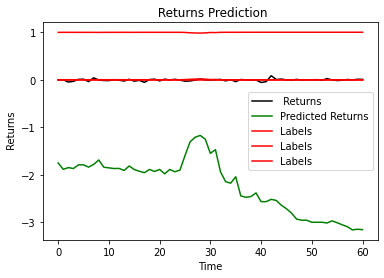

In [48]:
#plot results
plt.plot(yreturn[:61], color = 'black', label = ' Returns')
plt.plot(yhat1test, color = 'green', label = 'Predicted Returns')
plt.plot(yhat2test, color = 'red', label = 'Labels')
plt.title(' Returns Prediction')
plt.xlabel('Time')
plt.ylabel(' Returns')
plt.legend()
plt.show()

In [49]:
#train
epochs = 50
batch_size = 4
optimizer = keras.optimizers.SGD(learning_rate=0.0001)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
]
modelkeras.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
historyret = modelkeras.fit(
    trainxxprice,
    y_train_class,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    
)

Epoch 1/50
32/32 [==============================] - 1s 12ms/step - loss: 0.4144 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.2740 - val_sparse_categorical_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4439 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.2725 - val_sparse_categorical_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4038 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.2685 - val_sparse_categorical_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4167 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.2689 - val_sparse_categorical_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.4217 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.2655 - val_sparse_categorical_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 6/50
32/32 [======

In [50]:
#predict
yhatkeras = modelkeras.predict(x_totest)

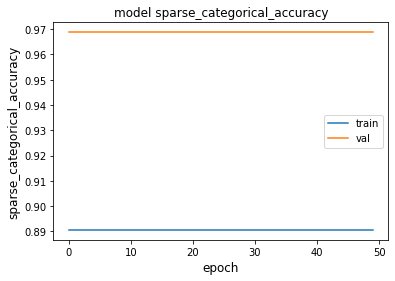

In [51]:
#plot results
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(historyret.history[metric])
plt.plot(historyret.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()